In [1]:
!git clone https://github.com/FedorZaitsev/VKR25
%cd VKR25

Cloning into 'VKR25'...
remote: Enumerating objects: 158, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 158 (delta 61), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (158/158), 1.38 MiB | 6.13 MiB/s, done.
Resolving deltas: 100% (61/61), done.
/kaggle/working/VKR25


In [2]:
import os
os.environ['TORCH_CUDA_ARCH_LIST']="5.0 5.2 5.3 6.0 6.1 6.2 7.0 7.2 7.5 8.0 8.6 8.7 8.9 9.0"

!pip install Ninja
!git clone https://github.com/c-hofer/torchph.git
!pip install -e torchph

import sys
sys.path.append("/kaggle/working/VKR25/torchph")

Cloning into 'torchph'...
remote: Enumerating objects: 2165, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 2165 (delta 7), reused 14 (delta 2), pack-reused 2129 (from 1)
Receiving objects: 100% (2165/2165), 7.54 MiB | 14.99 MiB/s, done.
Resolving deltas: 100% (1124/1124), done.
Obtaining file:///kaggle/working/VKR25/torchph
  Preparing metadata (setup.py) ... done
  Running setup.py develop for torchph


In [3]:
import os

config = {
    'SEED' : 228,
    
    'BOS_TOKEN' : 4096,
    'EOS_TOKEN' : 4097,
    'INP_PAD_TOKEN' : 4098,
    'TAR_PAD_TOKEN' : -100,
    'VOCAB_SIZE' : 4099,
    'MAX_LENGTH' : 256,
    'OVERLAP' : 64,
    
    'NUM_WORKERS' : 4,
    'BATCH_SIZE' : 16,

    'ACCUM_STEPS' : 1,
}

for key, value in config.items():
    os.environ[key] = str(value)

In [4]:
import torch
import random
import numpy as np

device = 'cuda'
root_dir = '/kaggle/input/groove-tokens'

torch.manual_seed(config['SEED'])
random.seed(config['SEED'])
np.random.seed(config['SEED'])

In [6]:
from models.topotransformer_model import TopoTransformerModel, PositionalEncoding, CustomTransformerEncoderLayer

In [8]:
model = torch.load('/kaggle/input/topotransformerv2/pytorch/default/1/checkpoint_50.pt', map_location=device)

/tmp/ipykernel_31/1672983669.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/kaggle/input/topotransformerv2/pytorch/default/1/checkpoint_50.pt', map

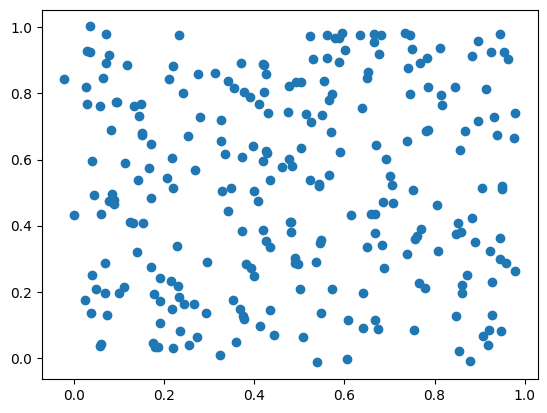

In [9]:
import matplotlib.pyplot as plt
centers = model.slayer.centers.detach().cpu().numpy()
radius = model.slayer.radius.detach().cpu().numpy()
plt.scatter(centers[:, 0], centers[:, 1])

In [10]:
from data import data

sequences = data.read_sequences(root_dir)
train_dataset, valid_dataset = data.get_train_val_dataset(sequences)

train_loader = data.get_loader(train_dataset)
valid_loader = data.get_loader(valid_dataset)

0it [00:00, ?it/s]/kaggle/working/VKR25/data/data.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sequences[i] = torch.load(filename, map_location=device).permute(2, 0,

In [11]:
i = 0
xs = []
for x, _ in train_loader:
    xs.append(x)
    i += 1
    if i == 10:
        break

In [14]:
from torchph import pershom
ph = pershom.pershom_backend.__C.VRCompCuda__vr_persistence_l1

In [15]:
import math

src = xs[4][:, :-1].to(device)
src_mask = model.generate_square_subsequent_mask(src.shape[1]).to(device)


src = model.embedding(src) * math.sqrt(model.d_model)
src = model.pos_encoder(src)

src = src.permute(1, 0, 2)
output = model.transformer(src, src_mask)
output = output.permute(1, 0, 2)

logits = model.linear(output)

# topo_logits = 0
# for i, inter_output in enumerate(self.transformer.intermediate_outputs):
#     topo_logits += self.topo_linear[i](self.slayer[i](torch.stack([ph(src_i, 0, 0)[0][0] for src_i in inter_output.permute(1, 0, 2)])))

topo_embeddings = model.slayer(torch.stack([ph(src_i, 0, 0)[0][0] for src_i in model.transformer.layers[-1].attention_weights.permute(0, 2, 1)]))
topo_logits = model.topo_linear(topo_embeddings)

logits = logits + topo_logits[:, None, :]

<Axes: >

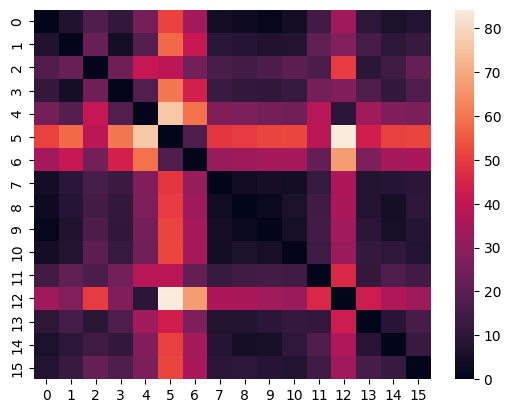

In [21]:
import seaborn as sns
sns.heatmap(torch.cdist(topo_logits, topo_logits, p=2.0).detach().cpu().numpy())

<Axes: >

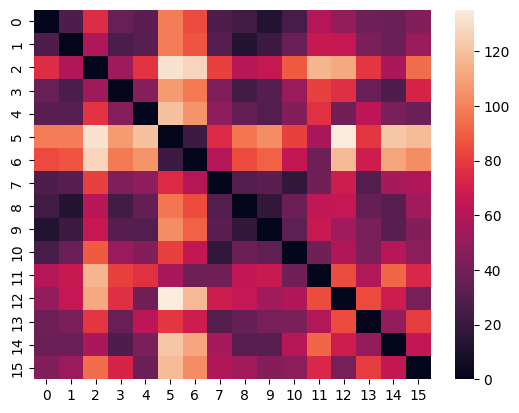

In [18]:
sns.heatmap(torch.cdist(topo_embeddings, topo_embeddings, p=2.0).detach().cpu().numpy())

<Axes: >

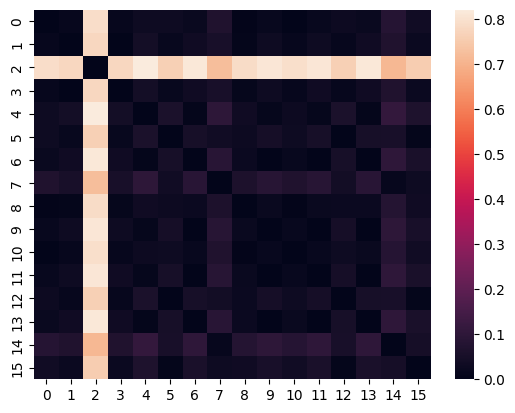

In [76]:
## Old arch 

# import numpy as np
# import seaborn as sns

# sns.heatmap(torch.cdist(topo_logits, topo_logits, p=2.0).detach().cpu().numpy())

In [ ]:
!pip install torchviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-1

In [37]:
x.shape

torch.Size([1, 256])

In [36]:
from torchviz import make_dot

# Create a simple model and input
model_trans = torch.load('/kaggle/input/huge_transf/pytorch/default/1/checkpoint_400.pt', map_location=device)
x = xs[0][:2][:-1].cuda()

# Forward pass
out_trans = model_trans(x)

# Visualize the graph
make_dot(out_trans, params=dict(model.named_parameters())).render("graph_transformer", format="png")

/tmp/ipykernel_31/4021338005.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_trans = torch.load('/kaggle/input/huge_transf/pytorch/default/1/checkpoint_400.pt', ma

'graph_transformer.png'

In [42]:
import copy
model_topo = copy.deepcopy(model)

In [43]:
for p in model_topo.parameters():
    p.requires_grad=True

out = model_topo(x)

# Visualize the graph
make_dot(out, params=dict(model.named_parameters())).render("graph_topotransformer", format="png")

'graph_topotransformer.png'